# Google Trend Forecasting

- Data: `https://sm-google-trend-public.s3.eu-central-1.amazonaws.com/agg/metadata.json`

In [1]:
import json
import pandas as pd

from urllib.request import urlopen

## Load Series

In [2]:
meta_json_path = "https://sm-google-trend-public.s3.eu-central-1.amazonaws.com/agg/metadata.json"

In [3]:
with urlopen(meta_json_path) as url:
    metadata = json.load(url)

In [4]:
metadata

[{'keyword': 'phone case',
  'cat': '0',
  'geo': 'DE',
  'timeframe': 'today 5-y',
  'path': 'https://sm-google-trend-public.s3.eu-central-1.amazonaws.com/agg/keyword=phone-case/cat=0/geo=de/timeframe=today-5-y/format=json/snapshot_date=latest/data.json'},
 {'keyword': 'curtain',
  'cat': '0',
  'geo': 'DE',
  'timeframe': 'today 5-y',
  'path': 'https://sm-google-trend-public.s3.eu-central-1.amazonaws.com/agg/keyword=curtain/cat=0/geo=de/timeframe=today-5-y/format=json/snapshot_date=latest/data.json'}]

In [5]:
selected_keyword = "phone case"
for i in metadata:
    if i["keyword"] == selected_keyword:
        df = pd.read_json(i["path"])

df.head()

,query,value,date
0,phone case,35,2018-08-05
1,phone case,49,2018-08-12
2,phone case,56,2018-08-19
3,phone case,48,2018-08-26
4,phone case,48,2018-09-02


## Timeseries

In [49]:
from darts import TimeSeries
from darts.models import AutoARIMA, LightGBMModel, RandomForest, TCNModel, TFTModel, ARIMA, NBEATSModel

In [7]:
ts = TimeSeries.from_dataframe(
    df=df, time_col="date", value_cols="value",
    freq="7D"
)

In [8]:
ts

<TimeSeries (DataArray) (date: 261, component: 1, sample: 1)>
array([[[ 35.]],

       [[ 49.]],

       [[ 56.]],

       [[ 48.]],

       [[ 48.]],

       [[ 70.]],

       [[ 58.]],

       [[ 49.]],

       [[ 76.]],

       [[ 54.]],

...

       [[ 74.]],

       [[ 77.]],

       [[ 75.]],

       [[ 77.]],

       [[ 79.]],

       [[ 85.]],

       [[ 78.]],

       [[ 78.]],

       [[ 78.]],

       [[ 89.]]])
Coordinates:
  * date       (date) datetime64[ns] 2018-08-05 2018-08-12 ... 2023-07-30
  * component  (component) object 'value'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [9]:
ts_length = len(ts)
ts_length

261

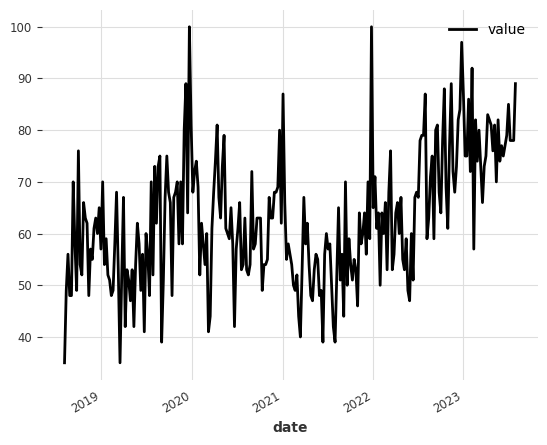

In [10]:
ts.plot()

In [11]:
horizon = 12

train_series_length = ts_length - horizon
test_series_length = horizon
train_series_length, test_series_length

(249, 12)

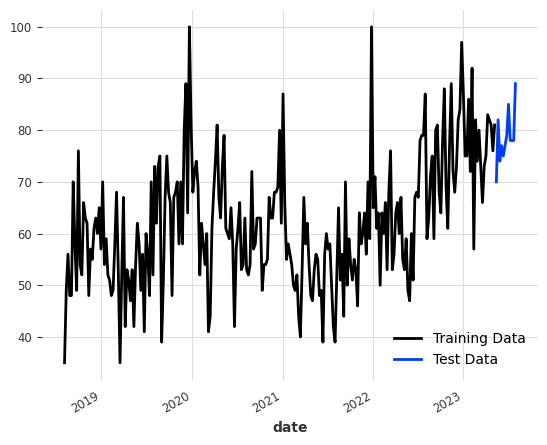

In [12]:
(
    ts_train,
    ts_test,
) = ts.split_before(train_series_length)

ts_train.plot(label="Training Data")
ts_test.plot(label="Test Data")

In [20]:
autoarima_args = dict(
    max_p=52,
    max_q=52
)

In [21]:
model = AutoARIMA(**autoarima_args)

In [22]:
model.fit(ts_train)

AutoARIMA(add_encoders=None, max_p=52, max_q=52)

In [23]:
model.model_params

OrderedDict([('add_encoders', None), ('max_p', 52), ('max_q', 52)])

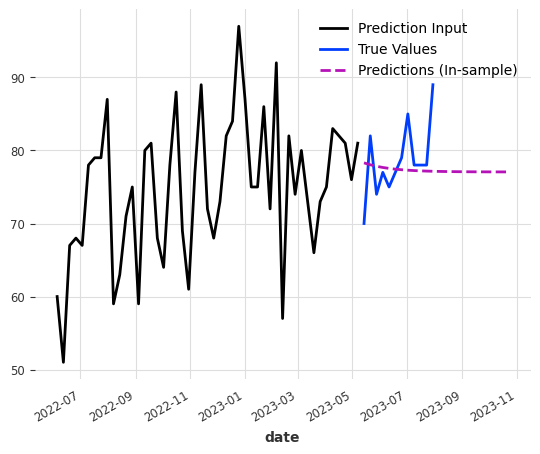

In [24]:
ts_train[200:].plot(label="Prediction Input")

ts_test.plot(label="True Values")

model.predict(
    n=horizon * 2,
).plot(label="Predictions (In-sample)", linestyle="--")

In [18]:
params_rf = dict(lags=52, output_chunk_length=horizon)
model_rf = RandomForest(**params_rf)


In [19]:
model_rf.fit(ts_train)

RandomForest(lags=52, lags_past_covariates=None, lags_future_covariates=None, output_chunk_length=12, add_encoders=None, n_estimators=100, max_depth=None, multi_models=True, use_static_covariates=True)

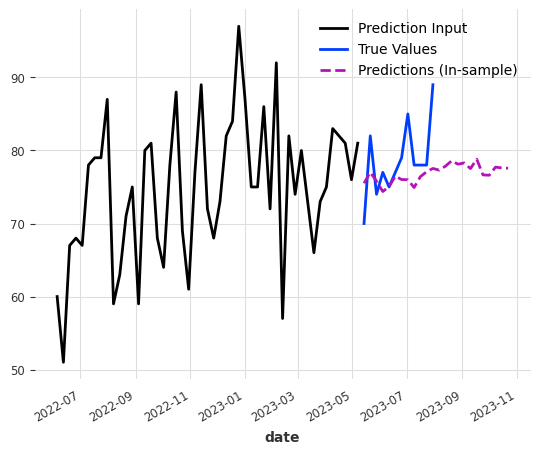

In [28]:
ts_train[200:].plot(label="Prediction Input")

ts_test.plot(label="True Values")

model_rf.predict(
    n=horizon * 2,
).plot(label="Predictions (In-sample)", linestyle="--")

In [29]:
from darts.utils.likelihood_models import GaussianLikelihood

In [30]:
model_tcn = TCNModel(
    input_chunk_length=52,
    output_chunk_length=horizon,
    dropout=0,
    likelihood=GaussianLikelihood()
)
model_tcn.fit(ts_train)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 226   
----------------------------------------------------
226       Trainable params
0         Non-trainable params
226       Total params
0.001     Total estimated model params size (MB)


Epoch 99: 100%|██████████| 6/6 [00:00<00:00, 59.52it/s, train_loss=916.0]  

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 6/6 [00:00<00:00, 56.85it/s, train_loss=916.0]


TCNModel(kernel_size=3, num_filters=3, num_layers=None, dilation_base=2, weight_norm=False, dropout=0, input_chunk_length=52, output_chunk_length=12, likelihood=<darts.utils.likelihood_models.GaussianLikelihood object at 0x13b7a8e20>)

In [34]:
pred_tcn = model_tcn.predict(horizon, series=ts_train, num_samples=100)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.99it/s]


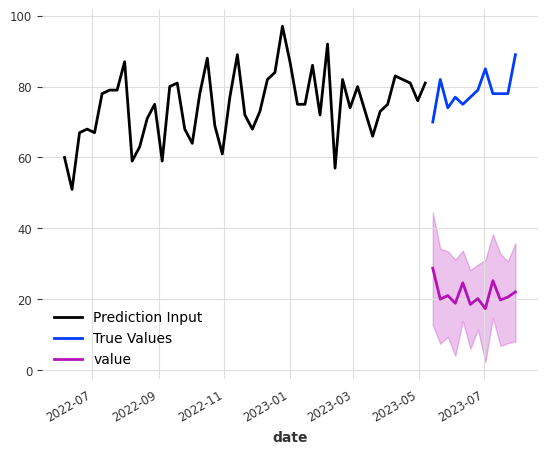

In [35]:
ts_train[200:].plot(label="Prediction Input")
ts_test.plot(label="True Values")

pred_tcn.plot()

In [37]:
model_tft = TCNModel(
    input_chunk_length=52,
    output_chunk_length=horizon,
    dropout=0,
    likelihood=GaussianLikelihood()
)

model_tft.fit(ts_train)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 226   
----------------------------------------------------
226       Trainable params
0         Non-trainable params
226       Total params
0.001     Total estimated model params size (MB)


Epoch 99: 100%|██████████| 6/6 [00:00<00:00, 46.73it/s, train_loss=9.39e+7]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 6/6 [00:00<00:00, 45.48it/s, train_loss=9.39e+7]


TCNModel(kernel_size=3, num_filters=3, num_layers=None, dilation_base=2, weight_norm=False, dropout=0, input_chunk_length=52, output_chunk_length=12, likelihood=<darts.utils.likelihood_models.GaussianLikelihood object at 0x13ba5e320>)

In [38]:
pred_tft = model_tft.predict(horizon, series=ts_train, num_samples=100)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]


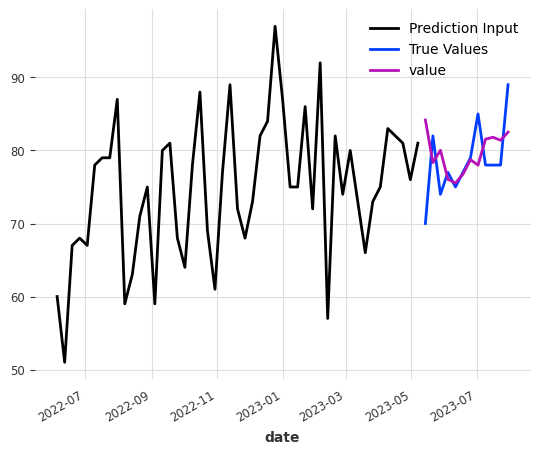

In [39]:
ts_train[200:].plot(label="Prediction Input")
ts_test.plot(label="True Values")

pred_tft.plot()

In [43]:
model_arima = ARIMA(p=12)
model_arima.fit(ts_train)

ARIMA(p=12, d=1, q=0, seasonal_order=(0, 0, 0, 0), trend=None, random_state=0, add_encoders=None)

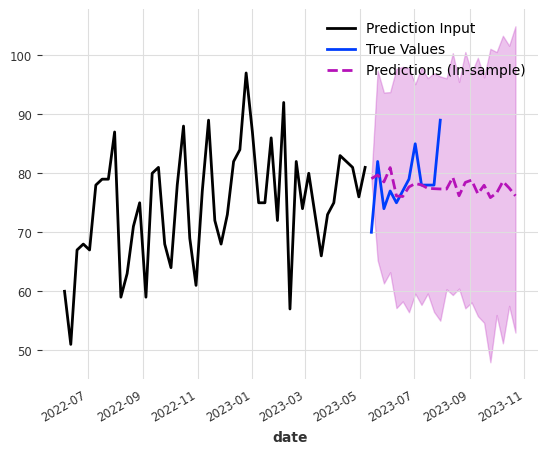

In [48]:
ts_train[200:].plot(label="Prediction Input")

ts_test.plot(label="True Values")

model_arima.predict(
    n=horizon * 2,
    num_samples=100
).plot(label="Predictions (In-sample)", linestyle="--")

In [51]:
model_nbeats = NBEATSModel(
    input_chunk_length=52,
    output_chunk_length=horizon,
    dropout=0,
    likelihood=GaussianLikelihood()
)

model_nbeats.fit(ts_train)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 6.5 M 
---------------------------------------------------
6.5 M     Trainable params
1.6 K     Non-trainable params
6.5 M     Total params
25.822    Total estimated model params size (MB)


Epoch 99: 100%|██████████| 6/6 [00:00<00:00,  6.66it/s, train_loss=2.22e+16]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 6/6 [00:00<00:00,  6.64it/s, train_loss=2.22e+16]


NBEATSModel(generic_architecture=True, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0, activation=ReLU, input_chunk_length=52, output_chunk_length=12, likelihood=<darts.utils.likelihood_models.GaussianLikelihood object at 0x142b89210>)

In [52]:
pred_nbeats = model_nbeats.predict(horizon, series=ts_train, num_samples=100)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.23it/s]


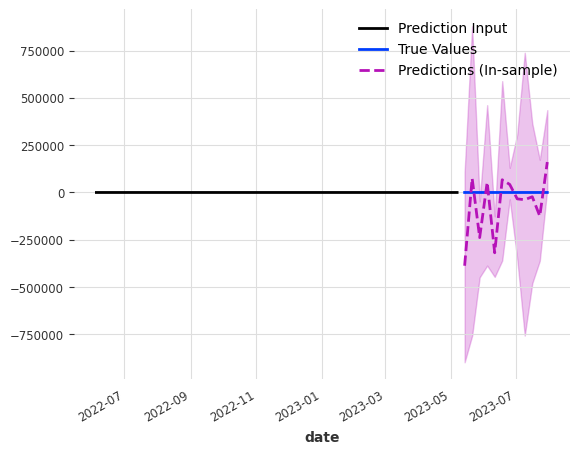

In [53]:
ts_train[200:].plot(label="Prediction Input")

ts_test.plot(label="True Values")

pred_nbeats.plot(label="Predictions (In-sample)", linestyle="--")